In [23]:
# Importing the python modules and the class ML_GRB from ML_GRB.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ML_GRB import ML_GRB

In [24]:
# Initializing the class and reading the Spectral data
dir_path = ''
my_class = ML_GRB()
my_class.DataReading(dir_path)

In [31]:
df = my_class.spectral_data_I

In [34]:
# Splitting the dataset in i and p
df_i = df[(df['SType'] == 'i')].reset_index(drop=True)
df_p = df[(df['SType'] == 'p')].reset_index(drop=True)

# Removing from "i data" the GRBs that are not in "p data" (Because the "i GRBs Dataset" is bigger than the
# "p GRBs Dataset").
# Creating a mask to mark if the i-th element is in the "p dataframe"
condictions = []
count = 0

temp = []
for i in df_i['ID']:
    condiction = i in df_p['ID'].values
    condictions.append(condiction)
    if condiction == False:
        temp.append(0)
        print(i)

# Using the mask to drop from "i dataframe" the row corresponding to GRBs that are not in "p dataframe"
for index, c in enumerate(condictions):
    if not c:
        df_i.drop(index, inplace=True)
        
print('\n')
print(len(temp))

GRB971214
GRB971214
GRB000301C
GRB000301C
GRB020819B
GRB020819B
GRB021211
GRB021211
GRB040924
GRB041006
GRB041006
GRB050922C
GRB050922C
GRB060121
GRB060121
GRB060912A
GRB061201
GRB061201
GRB070714B
GRB071010B
GRB071010B
GRB071020
GRB071020
GRB071112C
GRB071112C
GRB071117
GRB071117
GRB071227
GRB080413B
GRB080514B
GRB080514B
GRB080602
GRB081121
GRB081121
GRB090812
GRB090812
GRB091020
GRB091020
GRB100206A
GRB100816A
GRB100816A
GRB101213A
GRB101213A
GRB101219A
GRB101219A
GRB110731A
GRB110731A
GRB120804A
GRB120804A
GRB130408A
GRB130408A
GRB130603B
GRB130603B
GRB130701A
GRB130701A
GRB140506A
GRB140506A
GRB140606B
GRB140606B
GRB140808A
GRB140808A
GRB150424A
GRB150424A
GRB150514A
GRB150514A
GRB160410A
GRB160410A
GRB160629A
GRB160629A


69


In [8]:
# Selecting Band from the two dataframe ("i" and "p") and CPL (with beta = -2.5) if there isn't Band

# Filtering the i and p data with Band fit
df_i_Band = df_i[df_i['SMod'] == 'Band'].reset_index(drop=True)
df_p_Band = df_p[df_p['SMod'] == 'Band'].reset_index(drop=True)

# Creating two list to see wich GRBs that are in i or p dataset are not in the filtered dataset with Band fit
p_list = []
i_list = []
for p in df_p['ID']:
    if not p in df_p_Band['ID'].values:
        p_list.append(p)
    
for i in df_i['ID']:
    if not i in df_i_Band['ID'].values:
        i_list.append(i)
    
# printing the list to show the GRBs of interest
print(p_list)
print(i_list)
        

['GRB051109A', 'GRB080413A', 'GRB111008A']
['GRB111008A']


In [ ]:
# Creating two DataFrame with the GRBs of interest in their CPL fit
df_i_CPL = df_i[df_i['ID'].isin(i_list) & (df_i['SMod'] == 'CPL')]
df_p_CPL = df_p[df_p['ID'].isin(p_list) & (df_p['SMod'] == 'CPL')]

# Replace beta with -2.5
df_i_CPL.loc[:, 'beta'] = -2.5
df_p_CPL.loc[:, 'beta'] = -2.5

# Assembling the CPL and Band dataframe sorting by ID for comparing consistency reasons
df_i_Band_CPL = pd.concat([df_i_Band, df_i_CPL], ignore_index=True)
df_p_Band_CPL = pd.concat([df_p_Band, df_p_CPL], ignore_index=True)

# Sorting by ID for comparing consistency reasons
df_i_Band_CPL_sorted = df_i_Band_CPL.sort_values(by=['ID'])
df_p_Band_CPL_sorted = df_p_Band_CPL.sort_values(by=['ID'])

# Resetting the index after the sorting process
final_df_i = df_i_Band_CPL_sorted.reset_index(drop=True)
final_df_p = df_p_Band_CPL_sorted.reset_index(drop=True)

# Debug
for temp1, temp2 in zip(df_p_Band_CPL['ID'].values, df_i_Band_CPL['ID'].values):
    print('{}\t{}'.format(temp1, temp2))

In [ ]:
# Rename the columns name of the variables of interest
final_df_i = final_df_i.rename(columns={'alpha': 'alpha_i', 
                           'beta': 'beta_i', 
                           'Ep': 'Ep_i', 
                           'F': 'F_i'})

final_df_p = final_df_p.rename(columns={'alpha': 'alpha_p', 
                           'beta': 'beta_p', 
                           'Ep': 'Ep_p', 
                           'F': 'F_p'})

# Combining the values of interest of the "i data" and the "p data"
dataset = pd.concat([final_df_i[['ID', 'DeltaT', 'alpha_i', 'beta_i', 'Ep_i', 'F_i']], 
                     final_df_p[['alpha_p', 'beta_p', 'Ep_p', 'F_p']]], axis=1)

# Debug
dataset.style

In [11]:
# Extrating the redshift from the Burst Energetics data
BEdata = my_class.energetic_data

redshift = []
for name in dataset['ID']:
    temp_df = BEdata[BEdata['ID'] == name]
    z = temp_df.iloc[0]['z']
    redshift.append(z)
    
# Creating a dataframe for the redshift
temp_dict = {'z': redshift}
z_df = pd.DataFrame(temp_dict)

# Concatenating the dataset with the redshift dataframe
dataset = pd.concat([z_df, dataset[['DeltaT', 'alpha_i', 'beta_i', 'Ep_i', 
                                    'F_i', 'alpha_p', 'beta_p', 'Ep_p', 'F_p']]], 
                    axis=1)

# Debug
print(len(dataset['z'].values))

AttributeError: 'ML_GRB' object has no attribute 'energetic_data'

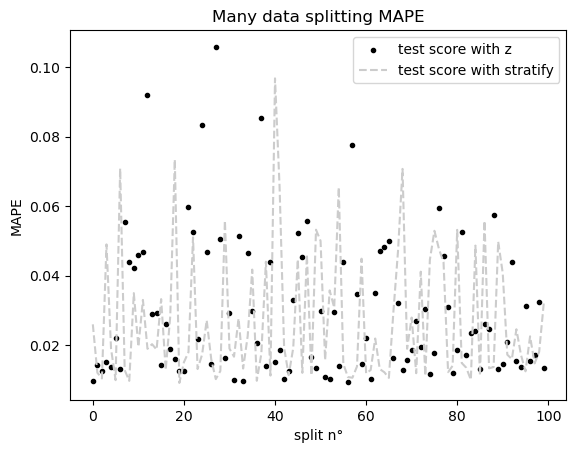

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from ML_GRB import ML_GRB, RND_FOREST

GRB = ML_GRB()
GRB.DataReading('')
GRB.DatasetExtrapolation()

dataset = GRB.dataset

# Inizialising the model class ---> see ML_GRB.py
model = RND_FOREST()
GRB.SetModel(model)     # Setting the model in the main class

random_seeds = np.random.randint(1000, size=100)

test_scores = []
test_scores_strat = []
for i in random_seeds:
    # Fitting the model ---> see functions.py
    GRB.model.Run(dataset, train_size = 0.8, 
                  n_estimators = 100, max_depth = 13, random_state = i)
    
    test_scores.append(mean_absolute_percentage_error(GRB.model.y_test, GRB.model.y_pred))

keys = []
for i in dataset['z']:
    if i <= 5:
        keys.append(0)
        
    elif i > 5:
        keys.append(1)
keys_arr = np.array(keys)

for i in random_seeds:
    # Fitting the model ---> see functions.py
    GRB.model.Run(dataset[['z', 'DeltaT','alpha_i', 'beta_i', 'Ep_i', 'F_i', 
                          'alpha_p', 'beta_p', 'Ep_p', 'F_p']], train_size = 0.8, stratify = keys_arr, 
                  n_estimators = 100, max_depth = 13, random_state = i)

    test_scores_strat.append(mean_absolute_percentage_error(GRB.model.y_test, GRB.model.y_pred))
    
fig, ax = plt.subplots()
ax.set(
    title = 'Many data splitting MAPE', 
    xlabel = 'split n°', 
    ylabel = 'MAPE'
)
ax.scatter(range(len(test_scores)), test_scores, marker='.', 
           color='k', label='test score with z')
ax.plot(range(len(test_scores_strat)), test_scores_strat, 
        linestyle='--', color='0.8', label='test score with stratify')
ax.legend(loc='best')
plt.show()

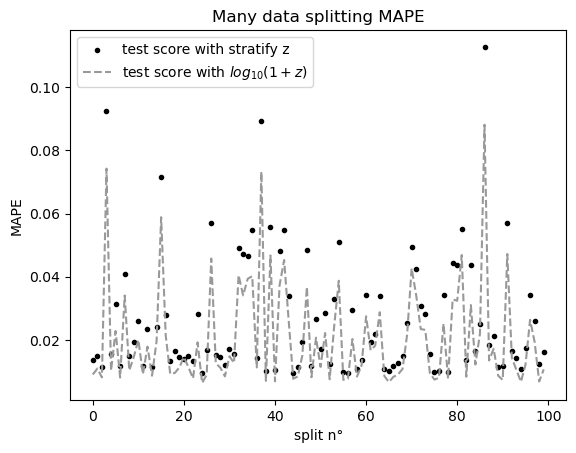

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from ML_GRB import ML_GRB, RND_FOREST

GRB = ML_GRB()
GRB.DataReading('')
GRB.DatasetExtrapolation()

dataset = GRB.dataset

random_seeds = np.random.randint(100000, size=100)

# Inizialising the model class ---> see ML_GRB.py
model = RND_FOREST()
GRB.SetModel(model)     # Setting the model in the main class

keys = []
for i in dataset['z']:
    if i <= 5:
        keys.append(0)
        
    elif i > 5:
        keys.append(1)
keys_arr = np.array(keys)

test_scores_strat = []
test_scores_cutted = []
test_scores_log = []
for i in random_seeds:
    # Fitting the model ---> see functions.py
    GRB.model.Run(dataset, train_size = 0.8, stratify=keys_arr, 
                  n_estimators = 500, max_depth = 13, random_state = i)
    
    test_scores_strat.append(mean_absolute_percentage_error(GRB.model.y_test, GRB.model.y_pred))

# dataset = dataset[dataset['z'] < 5]
# for i in random_seeds:
#     # Fitting the model ---> see functions.py
#     GRB.model.Run(dataset, train_size = 0.8, 
#                   n_estimators = 500, max_depth = 13, random_state = i)

#     test_scores_cutted.append(mean_absolute_percentage_error(GRB.model.y_test, GRB.model.y_pred))
    
dataset['z'] = np.log10(1 + dataset['z'])
for i in random_seeds:
    GRB.model.Run(dataset, train_size = 0.8, stratify=keys_arr, 
                  n_estimators = 500, max_depth = 13, random_state = i)
    
    test_scores_log.append(mean_absolute_percentage_error(GRB.model.y_test, GRB.model.y_pred))
    
fig, ax = plt.subplots()
ax.set(
    title = 'Many data splitting MAPE', 
    xlabel = 'split n°', 
    ylabel = 'MAPE'
)
ax.scatter(range(len(test_scores_strat)), test_scores_strat, marker='.', 
           color='k', label='test score with stratify z')
# ax.plot(range(len(test_scores_cutted)), test_scores_cutted, 
#         linestyle='--', color='0.8', label='test score with z < 5')
ax.plot(range(len(test_scores_log)), test_scores_log, linestyle='--', 
        color='0.6', label='test score with $log_{10}(1+z)$')
ax.legend(loc='best')
plt.savefig('images/MAPE_different_random_splits2.png')

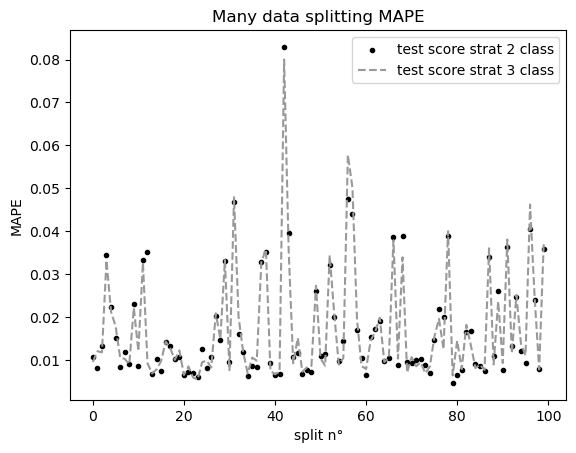

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from ML_GRB import ML_GRB, RND_FOREST

GRB = ML_GRB()
GRB.DataReading('')
GRB.DatasetExtrapolation()

dataset = GRB.dataset

random_seeds = np.random.randint(100000, size=100)

# Inizialising the model class ---> see ML_GRB.py
model = RND_FOREST()
GRB.SetModel(model)     # Setting the model in the main class

keys = []
for i in dataset['z']:
    if (i <= 5):
        keys.append(0)
        
    elif i > 5:
        keys.append(1)
        
keys_arr = np.array(keys)

test_scores_strat_2class = []
test_scores_strat_3class = []

dataset['z'] = np.log10(1 + dataset['z'])

for i in random_seeds:
    # Fitting the model ---> see functions.py
    GRB.model.Run(dataset, train_size = 0.8, stratify=keys_arr, 
                  n_estimators = 500, max_depth = 13, random_state = i)
    
    test_scores_strat_2class.append(mean_absolute_percentage_error(GRB.model.y_test, GRB.model.y_pred))
    
keys2 = []
for i in dataset['z']:
    if ((i <= 5) & (i >= 3)):
        keys2.append(1)
        
    elif i > 5:
        keys2.append(2)
        
    else:
        keys2.append(0)
    
keys2_arr = np.array(keys2)
    
for i in random_seeds:
    GRB.model.Run(dataset, train_size = 0.8, stratify=keys2_arr, 
                  n_estimators = 500, max_depth = 13, random_state = i)
    
    test_scores_strat_3class.append(mean_absolute_percentage_error(GRB.model.y_test, GRB.model.y_pred))
    
fig, ax = plt.subplots()
ax.set(
    title = 'Many data splitting MAPE', 
    xlabel = 'split n°', 
    ylabel = 'MAPE'
)
ax.scatter(range(len(test_scores_strat_2class)), test_scores_strat_2class, marker='.', 
           color='k', label='test score strat 2 class')
ax.plot(range(len(test_scores_strat_3class)), test_scores_strat_3class, linestyle='--', 
        color='0.6', label='test score strat 3 class')
ax.legend(loc='best')
plt.savefig('images/MAPE_different_random_splits3.png')

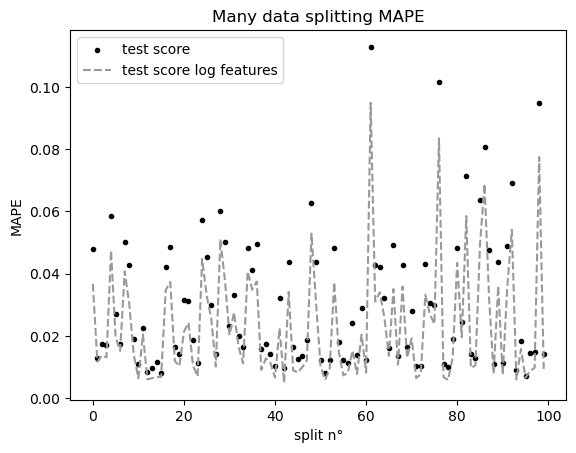

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from ML_GRB import ML_GRB, RND_FOREST

GRB = ML_GRB()
GRB.DataReading('')
GRB.DatasetExtrapolation()

dataset = GRB.dataset

random_seeds = np.random.randint(100000, size=100)

# Inizialising the model class ---> see ML_GRB.py
model = RND_FOREST()
GRB.SetModel(model)     # Setting the model in the main class

keys = []
for i in dataset['z']:
    if (i <= 5):
        keys.append(0)
        
    elif i > 5:
        keys.append(1)
        
keys_arr = np.array(keys)

test_scores_strat = []
test_scores_strat_log = []

for i in random_seeds:
    # Fitting the model ---> see functions.py
    GRB.model.Run(dataset, train_size = 0.8, stratify=keys_arr, 
                  n_estimators = 500, max_depth = 13, random_state = i)
    
    test_scores_strat.append(mean_absolute_percentage_error(GRB.model.y_test, GRB.model.y_pred))
    
dataset['z'] = np.log10(1 + dataset['z'])
dataset[['DeltaT', 'Ep_i', 'F_i', 'Ep_p', 'F_p']] = np.log10(dataset[['DeltaT', 'Ep_i', 'F_i', 'Ep_p', 'F_p']])  

for i in random_seeds:
    GRB.model.Run(dataset, train_size = 0.8, stratify=keys_arr, 
                  n_estimators = 500, max_depth = 13, random_state = i)
    
    test_scores_strat_log.append(mean_absolute_percentage_error(GRB.model.y_test, GRB.model.y_pred))
    
fig, ax = plt.subplots()
ax.set(
    title = 'Many data splitting MAPE', 
    xlabel = 'split n°', 
    ylabel = 'MAPE'
)
ax.scatter(range(len(test_scores_strat)), test_scores_strat, marker='.', 
           color='k', label='test score')
ax.plot(range(len(test_scores_strat_log)), test_scores_strat_log, linestyle='--', 
        color='0.6', label='test score log features')
ax.legend(loc='best')
# plt.savefig('images/MAPE_different_random_splits3.png')
plt.show()

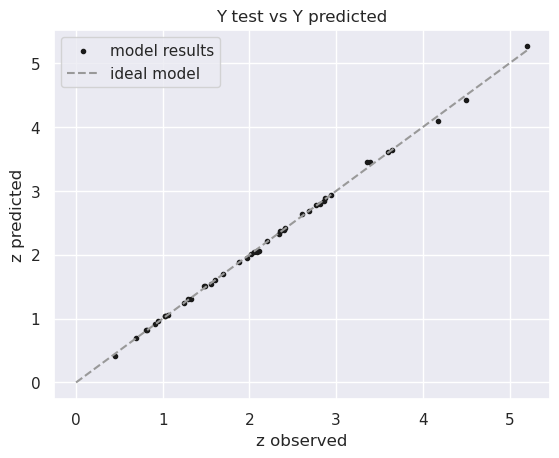

The correlation r is : 0.99956 and the p-value is 0.00000 while the MAPE is: 0.01131


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
from scipy import stats
from ML_GRB import ML_GRB, RND_FOREST

GRB = ML_GRB()
GRB.DataReading('')
GRB.DatasetExtrapolation()

dataset = GRB.dataset

model = RND_FOREST()
GRB.SetModel(model)     # Setting the model in the main class

keys = []
for i in dataset['z']:
    if (i <= 5):
        keys.append(0)
        
    elif (i > 5):
        keys.append(1)
        
keys_arr = np.array(keys)

dataset['z'] = np.log10(1 + dataset['z'])
dataset[['DeltaT', 'Ep_i', 'F_i', 'Ep_p', 'F_p']] = np.log10(dataset[['DeltaT', 'Ep_i', 'F_i', 'Ep_p', 'F_p']])  

# Fitting the model ---> see functions.py
GRB.model.Run(dataset, train_size = 0.8, stratify=keys_arr, 
              n_estimators = 500, max_depth = 13)

z_test_list = []
z_pred_list = []
for test, pred in zip(GRB.model.y_test, GRB.model.y_pred):
       z_test = 10**test - 1
       z_pred = 10**pred - 1
       z_test_list.append(z_test)
       z_pred_list.append(z_pred)

# Computing the results
correlation_coefficient, p_value = stats.pearsonr(z_test_list, z_pred_list)
mape = mean_absolute_percentage_error(z_test_list, z_pred_list)

# Plotting predictions vs test data
fig, ax = plt.subplots()
ax.set(title = 'Y test vs Y predicted', 
       xlabel = 'z observed', 
       ylabel = 'z predicted')

ax.scatter(z_test_list, z_pred_list, color='k', marker='.', label='model results')

# Plotting a bisector that act as an ideal model
x_values = np.linspace(0, max(z_test_list), 100)
ax.plot(x_values, x_values, color='0.6', linestyle = '--', label='ideal model')

ax.legend(loc='best')
plt.show()
    
# Printing the results
print('The correlation r is : {:.5f} and the p-value is {:.5f} while the MAPE is: {:.5f}'.format(correlation_coefficient, p_value, mape))

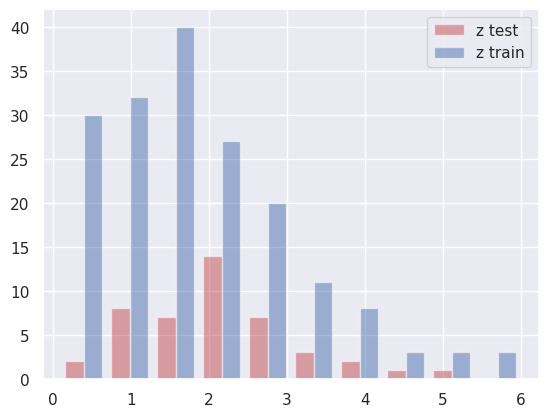

In [14]:
z_test_list = []
z_train_list = []
for test in GRB.model.y_test:
       z_test = 10**test - 1
       z_test_list.append(z_test)
       
for train in GRB.model.y_train:
       z_train = 10**train - 1
       z_train_list.append(z_train)

sns.set_theme()  # <-- This actually changes the look of plots.
plt.hist([z_test_list, z_train_list], color=['r','b'], alpha=0.5, label=['z test', 'z train'])
plt.legend(loc='best')

In [8]:
len(z_test_list)

45

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ML_GRB import ML_GRB, RND_FOREST

dir_path = ''       # directory path

GRB = ML_GRB()      # initializing the main class ---> see ML_GRB.py
GRB.DataReading(dir_path)       # reading the data ---> see functions.py

GRB.DatasetExtrapolation()      # creating the dataset ---> see function.py
dataset = GRB.dataset       # saving the dataset in a variable

a, b = GRB.energetic_data_I, GRB.energetic_data_II

print(len(a) + len(b))

print(len(dataset))

317
222


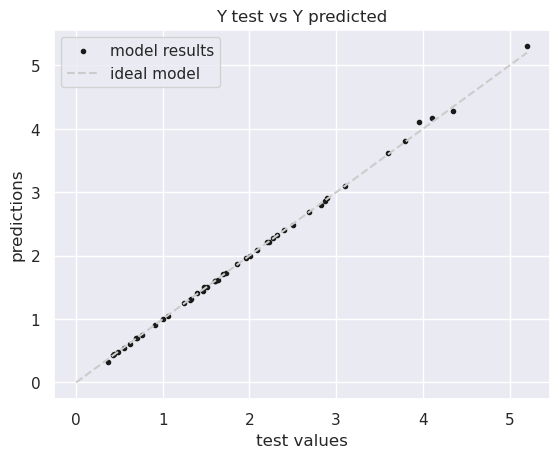

The r2 score is : 0.99917 while the MAPE is: 0.01149


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
from ML_GRB import ML_GRB, RND_FOREST

GRB = ML_GRB()
GRB.DataReading('')
GRB.DatasetExtrapolation()

dataset = GRB.dataset

model = RND_FOREST()
GRB.SetModel(model)     # Setting the model in the main class

keys = []
for i in dataset['z']:
    if (i <= 4) & (i > 3):
        keys.append(0)
        
    elif (i <= 5) & (i > 4):
        keys.append(1)

    elif (i <= 5.5) & (i > 5):
        keys.append(2)
        
    elif i > 5.5:
        keys.append(3)
    
    else:
        keys.append(4)
        
keys_arr = np.array(keys)

# Fitting the model ---> see functions.py
GRB.model.Run(dataset, train_size = 0.8, stratify=keys_arr, 
              n_estimators = 500, max_depth = 13)

# Importing the RMSE metrics from scikit-learn
from sklearn.metrics import root_mean_squared_error

# Computing the results
test_score = GRB.model.forest.score(GRB.model.X_test, GRB.model.y_test)
mape = mean_absolute_percentage_error(GRB.model.y_test, GRB.model.y_pred)

# Plotting predictions vs test data
fig, ax = plt.subplots()
ax.set(title = 'Y test vs Y predicted', 
       xlabel = 'test values', 
       ylabel = 'predictions')

ax.scatter(GRB.model.y_test, GRB.model.y_pred, color='k', marker='.', label='model results')

# Plotting a bisector that act as an ideal model
x_values = np.linspace(0, max(GRB.model.y_test), 100)
ax.plot(x_values, x_values, color='0.8', linestyle = '--', label='ideal model')

ax.legend(loc='best')
plt.show()
    
# Printing the results
print('The r2 score is : {:.5f} while the MAPE is: {:.5f}'.format(test_score, mape))

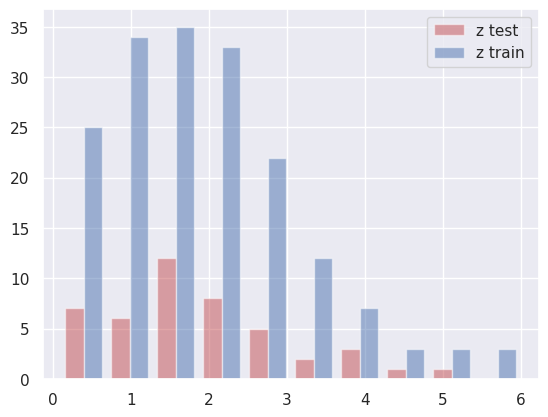

In [22]:
sns.set_theme()  # <-- This actually changes the look of plots.
plt.hist([GRB.model.y_test, GRB.model.y_train], color=['r','b'], alpha=0.5, label=['z test', 'z train'])
plt.legend(loc='best')

In [18]:
a = dataset[dataset['z'] > 5].to_numpy()

print(a[:,0])

[5.3    5.4636 5.2    6.     5.91   5.283 ]
